In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from time import time

In [2]:
df = pd.read_csv("avg_top10_bootstrapped.csv")

In [3]:
df = df.astype({"attacked": int})

In [4]:
df.shape

(2567, 9)

In [5]:
df['attacked'].value_counts()

1    1559
0    1008
Name: attacked, dtype: int64

In [7]:
df

,vx_sd,z_sd,qbn_3,yaw,roll,pitch,vu,ve,attacked
0,0.000362,0.013414,-0.344576,0.283453,0.011166,-0.011591,0.027276,1.030855,1
1,0.000362,0.013414,-0.344576,0.283453,0.011167,-0.011591,0.027276,1.030856,1
2,0.000362,0.013412,-0.344574,0.283450,0.011144,-0.011635,0.027373,1.030864,1
3,0.000362,0.013414,-0.344576,0.283453,0.011167,-0.011590,0.027276,1.030855,1
4,0.000362,0.013414,-0.344576,0.283453,0.011167,-0.011591,0.027277,1.030856,1
...,...,...,...,...,...,...,...,...,...
2562,0.000321,0.012983,-0.225716,-0.189185,0.018952,-0.015571,-0.001042,0.894214,0
2563,0.000619,0.020857,-0.099571,-0.200844,0.033292,-0.011853,-0.314484,4.335335,0
2564,0.000372,0.013745,0.337224,-0.224563,0.001273,-0.016793,-0.013438,-0.498978,0
2565,0.000403,0.000902,-0.153147,-0.390233,0.000809,-0.022833,-0.019146,0.590505,0


In [8]:
average_data = df.drop('attacked', axis=1)

df_scaled = StandardScaler().fit_transform(average_data)
scaled_df = pd.DataFrame(df_scaled, columns=average_data.columns)

In [9]:
pca = PCA(n_components=.95).fit(scaled_df)
transformed_df = pca.transform(scaled_df)

print('Original dimensions: ', scaled_df.shape)
print('PCA dimensions: ', transformed_df.shape)

Original dimensions:  (2567, 8)
PCA dimensions:  (2567, 4)


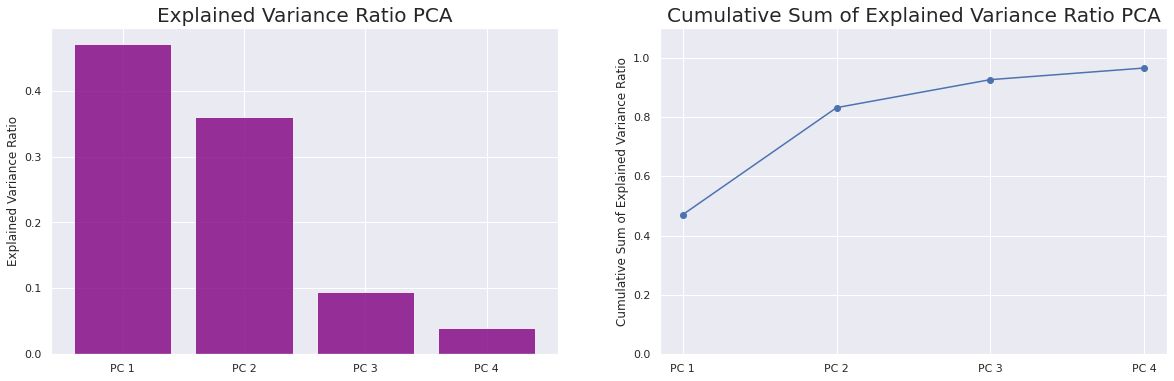

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax1.set_ylabel('Explained Variance Ratio')

# ratio[0]=0
ratio = pca.explained_variance_ratio_
ax2.plot(np.cumsum(ratio), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

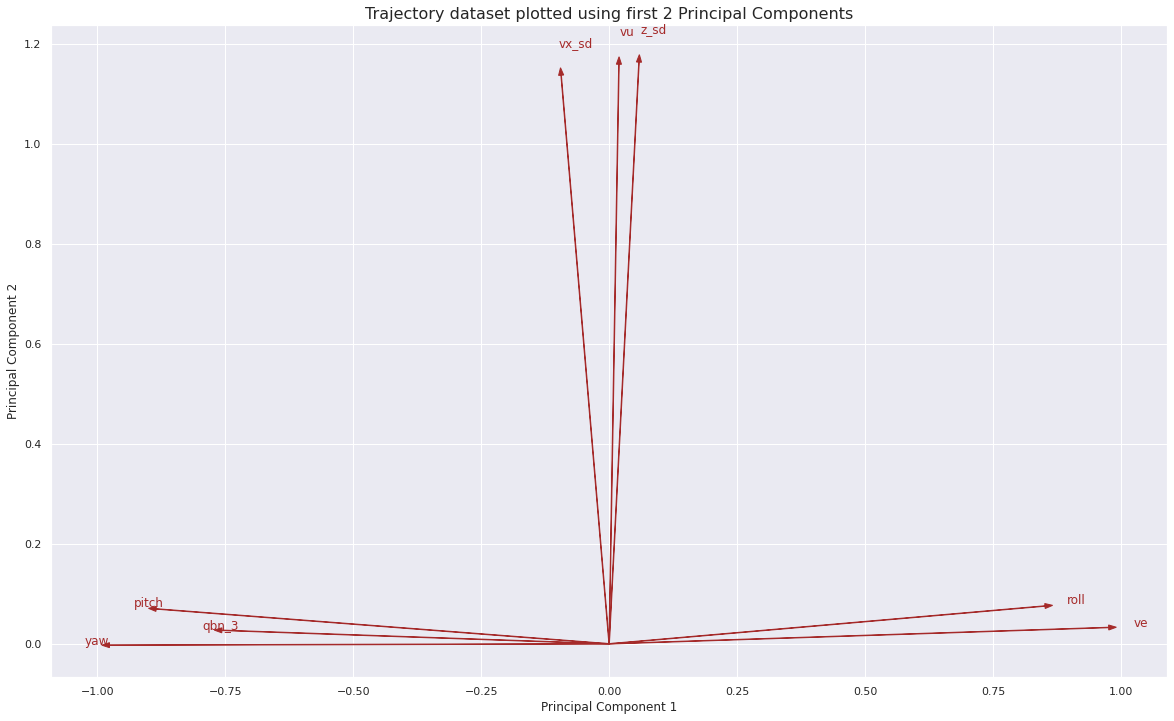

In [11]:
# to plot vectors from the center
vecs = pca.components_[0:8].T *2

fig, ax = plt.subplots(figsize=(20,12))
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Trajectory dataset plotted using first 2 Principal Components', fontsize=16)

# plotting arrowheads of the original axes projected on the 2D PCA space
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.01)
    s = 1.05
    ax.annotate(scaled_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

In [12]:
# Define columns to consider for outlier removal
columns_to_consider = df.columns[df.columns != 'attacked']

# Compute z-scores for each column excluding 'attacked'
z_scores = np.abs(stats.zscore(df[columns_to_consider]))

# Set threshold
threshold_z = 2.5

# Find outlier indices where any column's z-score exceeds the threshold
outlier_indices = np.where(np.any(z_scores > threshold_z, axis=1))[0]

# Remove outliers from DataFrame
no_outliers = df.drop(outlier_indices)

# Display shapes
print("Original DataFrame Shape:", df.shape)
print("DataFrame Shape after Removing Outliers:", no_outliers.shape)

Original DataFrame Shape: (2567, 9)
DataFrame Shape after Removing Outliers: (2527, 9)


In [13]:
no_outliers['attacked'].value_counts()

1    1519
0    1008
Name: attacked, dtype: int64

In [14]:
X = no_outliers.iloc[:, :-1]
y = no_outliers.iloc[:, -1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

In [16]:
scaler = StandardScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
normalized_x_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [17]:
# Define hyperparameters grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Create logistic regression model
logreg = LogisticRegression()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(normalized_x_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [18]:
#LR = LogisticRegression().fit(normalized_x_train, y_train)

# Fit the logistic regression model with best parameters
best_logreg = LogisticRegression(**best_params, class_weight='balanced')
best_logreg.fit(normalized_x_train, y_train)

y_preds_train = best_logreg.predict(normalized_x_train)
y_test_pred = best_logreg.predict(normalized_x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)
print("Accuracy on Test Set:", accuracy)

Best Parameters: {'C': 10}
Best Accuracy: 0.8223701259014791
Accuracy on Test Set: 0.8241106719367589


In [19]:
full_logreg_score_train = accuracy_score(y_train, y_preds_train)
full_logreg_score_test = accuracy_score(y_test, y_test_pred)
precision_score1 = precision_score(y_test, y_test_pred)
recall_score = recall_score(y_test, y_test_pred)
f1_score = f1_score(y_test, y_test_pred)

print('Training Set Score: {}'.format(full_logreg_score_train))
print('Test Set Score: {}'.format(full_logreg_score_test))
print('Precision Score: {}'.format(precision_score1))
print('Recall Score: {}'.format(recall_score))
print('F1 Score: {}'.format(f1_score))

Training Set Score: 0.8624443344878773
Test Set Score: 0.8241106719367589
Precision Score: 0.8868613138686131
Recall Score: 0.8073089700996677
F1 Score: 0.8452173913043477


In [20]:
coefficients = best_logreg.coef_[0]

<AxesSubplot:ylabel='Feature'>

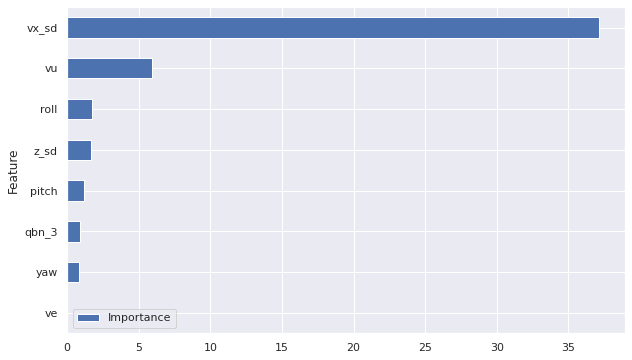

In [21]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

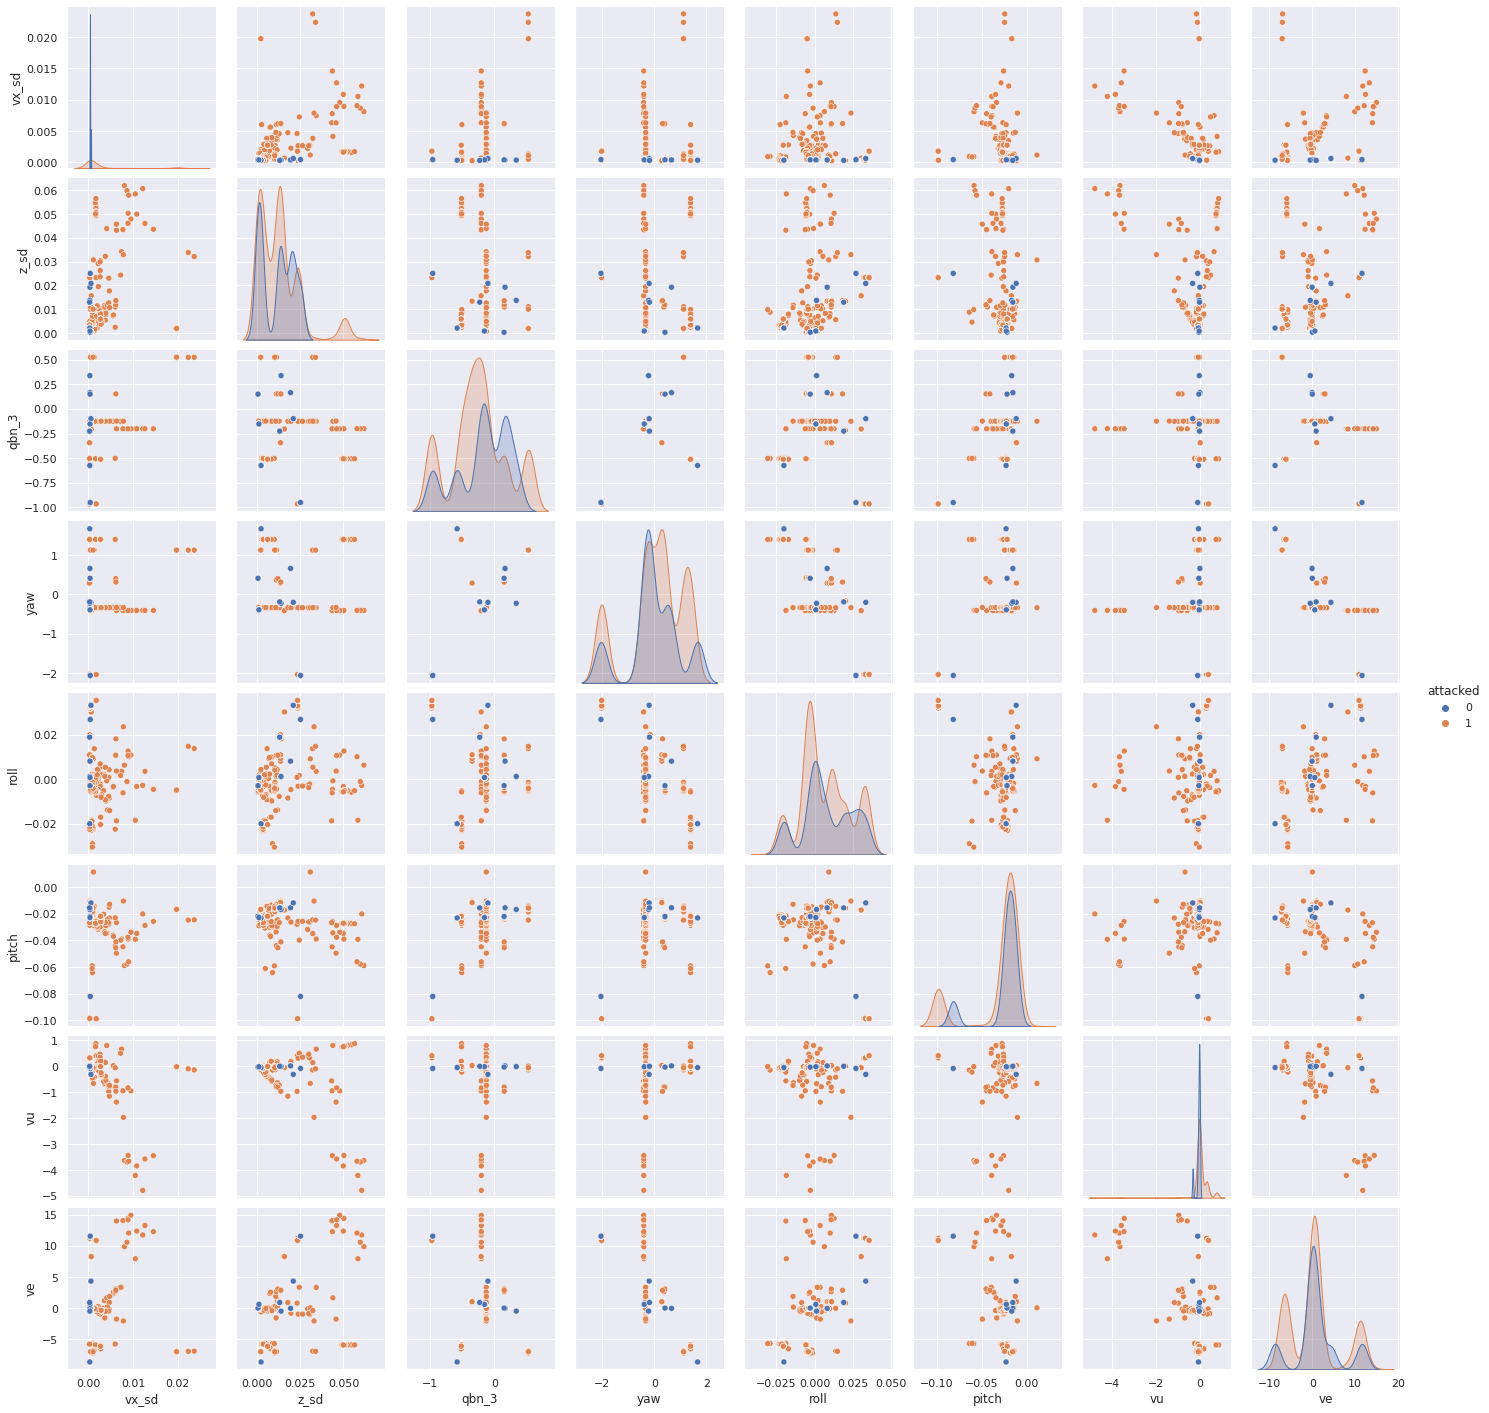

In [22]:
sns.pairplot(no_outliers, hue="attacked")